In [5]:
require(rstan)
require(rstanarm)
require(HSAUR3)
options(mc.cores = 2)


Loading required package: HSAUR3
Loading required package: tools


In [29]:
data("womensrole", package = "HSAUR3")
womensrole$total <- womensrole$agree + womensrole$disagree
head(womensrole, 2)
summary(womensrole)
womensrole

education,gender,agree,disagree,total
0,Male,4,2,6
1,Male,2,0,2


   education     gender       agree           disagree          total       
 Min.   : 0   Male  :21   Min.   :  0.00   Min.   :  0.00   Min.   :  0.00  
 1st Qu.: 5   Female:21   1st Qu.:  3.25   1st Qu.:  4.25   1st Qu.: 10.00  
 Median :10               Median : 13.00   Median : 22.00   Median : 32.00  
 Mean   :10               Mean   : 24.29   Mean   : 44.07   Mean   : 68.36  
 3rd Qu.:15               3rd Qu.: 28.75   3rd Qu.: 56.50   3rd Qu.:100.50  
 Max.   :20               Max.   :190.00   Max.   :403.00   Max.   :593.00  

education,gender,agree,disagree,total
0,Male,4,2,6
1,Male,2,0,2
2,Male,4,0,4
3,Male,6,3,9
4,Male,5,5,10
5,Male,13,7,20
6,Male,25,9,34
7,Male,27,15,42
8,Male,75,49,124
9,Male,29,29,58


Fit a logistic model using GLM in frequentist approach

In [15]:

womensrole_glm_1 <- glm(cbind(agree, disagree) ~ education + gender,
                        data = womensrole, family = binomial(link = "logit"))
round(coef(summary(womensrole_glm_1)), 3)

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),2.509,0.184,13.646,0.000
education,-0.271,0.015,-17.560,0.000
genderFemale,-0.011,0.084,-0.136,0.892


Fit a similar mode, but with Student T priors in rstanarm:

In [18]:
CHAINS = 2
CORES  = 2
SEED   = 42
womensrole_bglm_1 <- stan_glm(cbind(agree, disagree) ~ education + gender,
                              data = womensrole,
                              family = binomial(link = "logit"), 
                              prior = student_t(df = 7), 
                              prior_intercept = student_t(df = 7),
                              chains = CHAINS, cores = CORES, 
                              seed = SEED)
womensrole_bglm_1

stan_glm
 family:       binomial [logit]
 formula:      cbind(agree, disagree) ~ education + gender
 observations: 42
 predictors:   3
------
             Median MAD_SD
(Intercept)   2.5    0.2  
education    -0.3    0.0  
genderFemale  0.0    0.1  

Sample avg. posterior predictive distribution of y:
         Median MAD_SD
mean_PPD 24.3    0.8  

------
For info on the priors used see help('prior_summary.stanreg').

We can use the `posterior_interval` function to obtain a Bayesian uncertainty interval for β1:

In [21]:
ci95 <- posterior_interval(womensrole_bglm_1, prob=0.95, pars="education")
round(ci95, 2)

,2.5%,97.5%
education,-0.3,-0.24


In [22]:
cbind(Median = coef(womensrole_bglm_1), MAD_SD = se(womensrole_bglm_1))

,Median,MAD_SD
(Intercept),2.50782789,0.17671935
education,-0.27067414,0.01477415
genderFemale,-0.01215774,0.09276109


In [24]:
y_rep <- posterior_predict(womensrole_bglm_1)
dim(y_rep)

[1] 2000   42

The resulting matrix has rows equal to the number of posterior simulations, which in this case is 2000 and columns equal to the number of observations in the original dataset, which is 42 combinations of education and gender.

We can try the 10th combination to see how the outcome looks like:

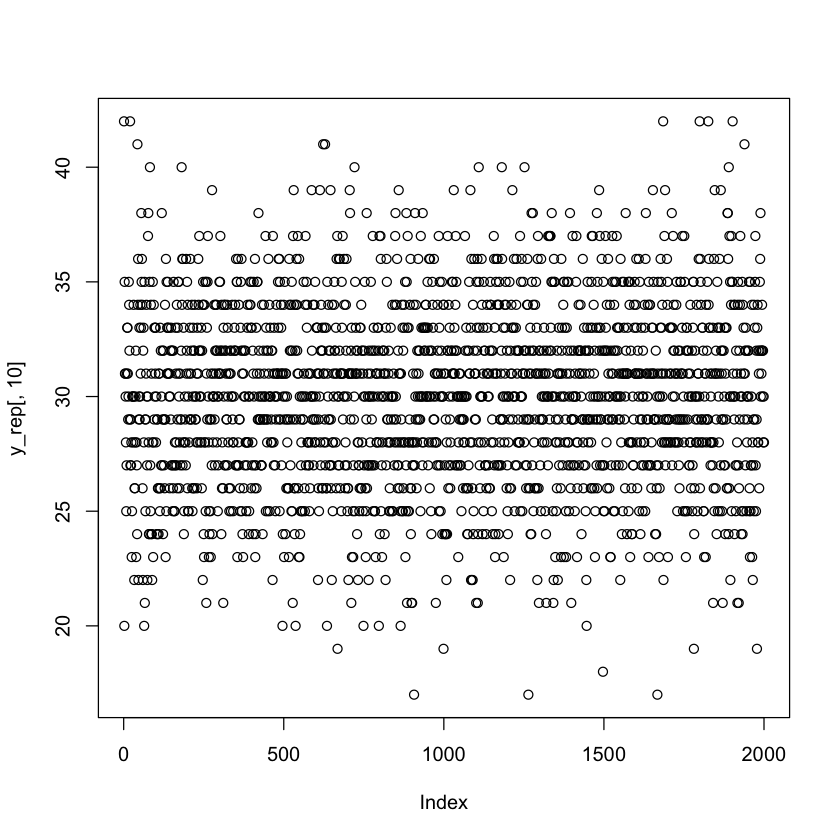

In [37]:
plot(y_rep[, 10])

Each element of this matrix is a predicted number of respondents with that value of education and gender who agreed with the survey question and thus should be reasonably close to the observed proportion of agreements in the data. We can create a plot to check this:

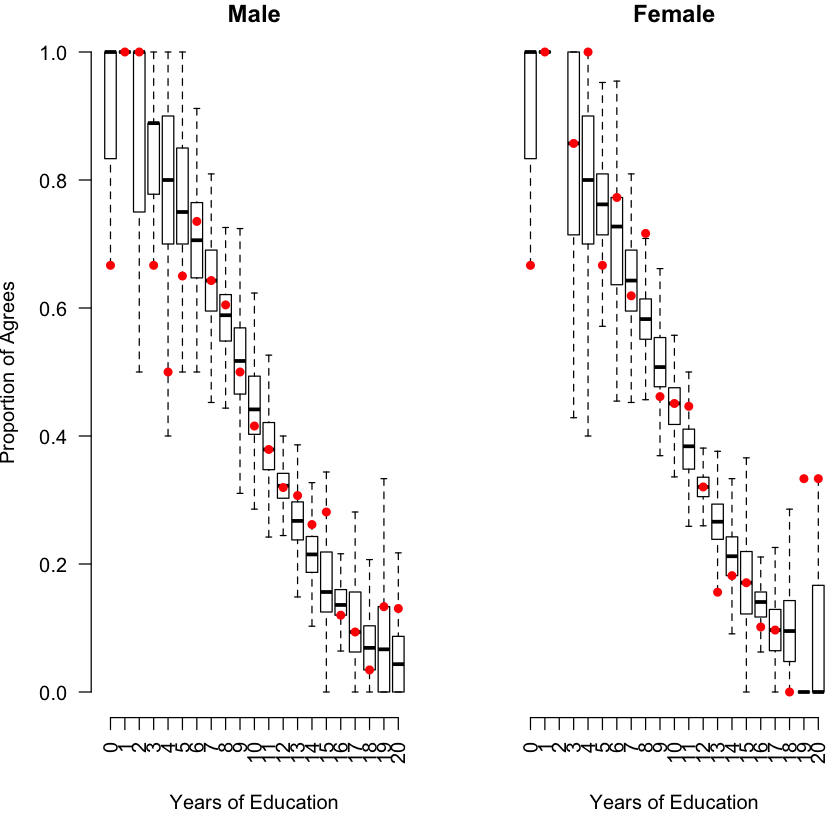

In [38]:
par(mfrow = 1:2, mar = c(5,3.7,1,0) + 0.1, las = 3)
boxplot(sweep(y_rep[,womensrole$gender == "Male"], 2, STATS = 
               womensrole$total[womensrole$gender == "Male"], FUN = "/"), 
        axes = FALSE, main = "Male", pch = NA,
        xlab = "Years of Education", ylab = "Proportion of Agrees")
with(womensrole, axis(1, at = education[gender == "Male"] + 1, 
                      labels = 0:20))
axis(2, las = 1)
with(womensrole[womensrole$gender == "Male",], 
     points(education + 1,  agree / (agree + disagree), 
            pch = 16, col = "red"))
boxplot(sweep(y_rep[,womensrole$gender == "Female"], 2, STATS = 
          womensrole$total[womensrole$gender == "Female"], FUN = "/"), 
          axes = FALSE, main = "Female", pch = NA,
        xlab = "Years of Education", ylab = "")
with(womensrole, axis(1, at = education[gender == "Female"] + 1,
     labels = 0:20))
with(womensrole[womensrole$gender == "Female",], 
     points(education + 1,  agree / (agree + disagree), 
            pch = 16, col = "red"))


<center> <b>Posterior predictive boxplots vs. observed datapoints</b> </center>
